# Imports and setup

Need to figure out what to do about galstreams tracks ending within the region of the data. For streams in high density proper motion spaces, this is causing a problem.

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [3]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [4]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-Jhelum.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [5]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='Jhelum'

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


        Use @ instead. [gala.coordinates.greatcircle]


2.6490062005275154e-05
Fitting for peak pm location
Pre-fitting mean PM values: -7.480845476411462, 3.4170918408421267
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-7.24902249317148, 3.450832105310474, 0.7593575095703737, 0.42505700095023446] 

Producing the polygon and mask


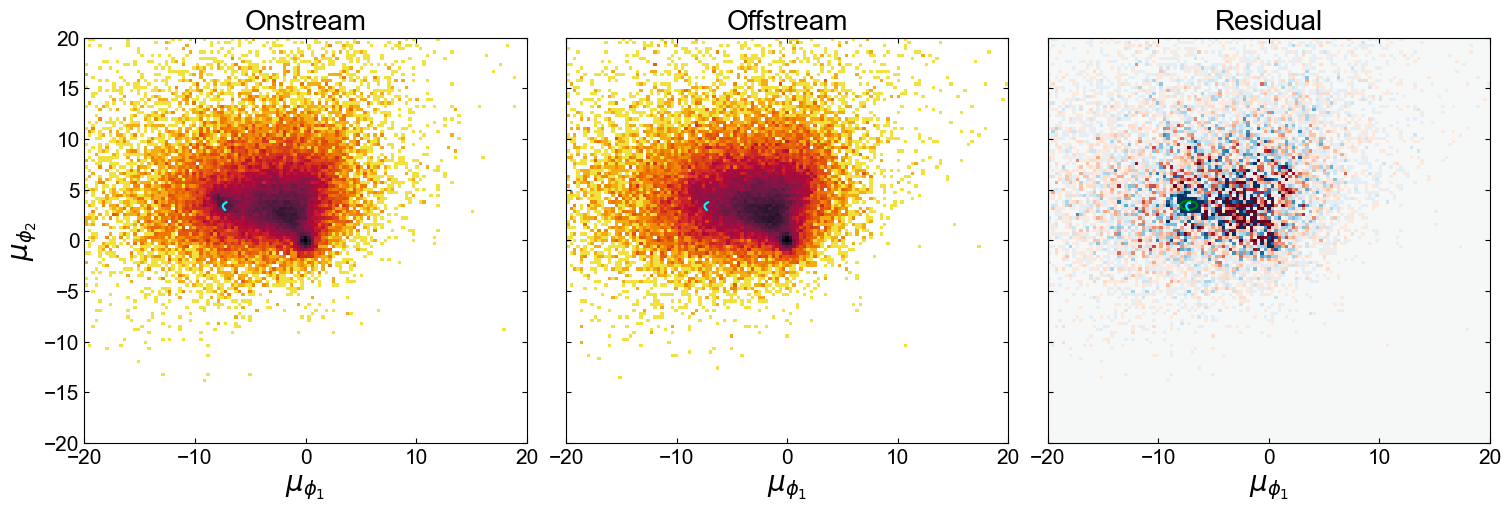

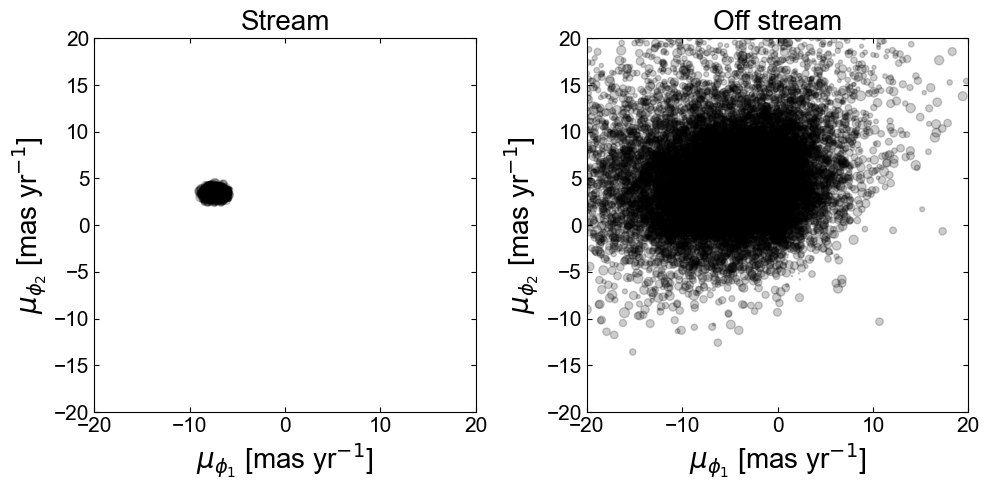

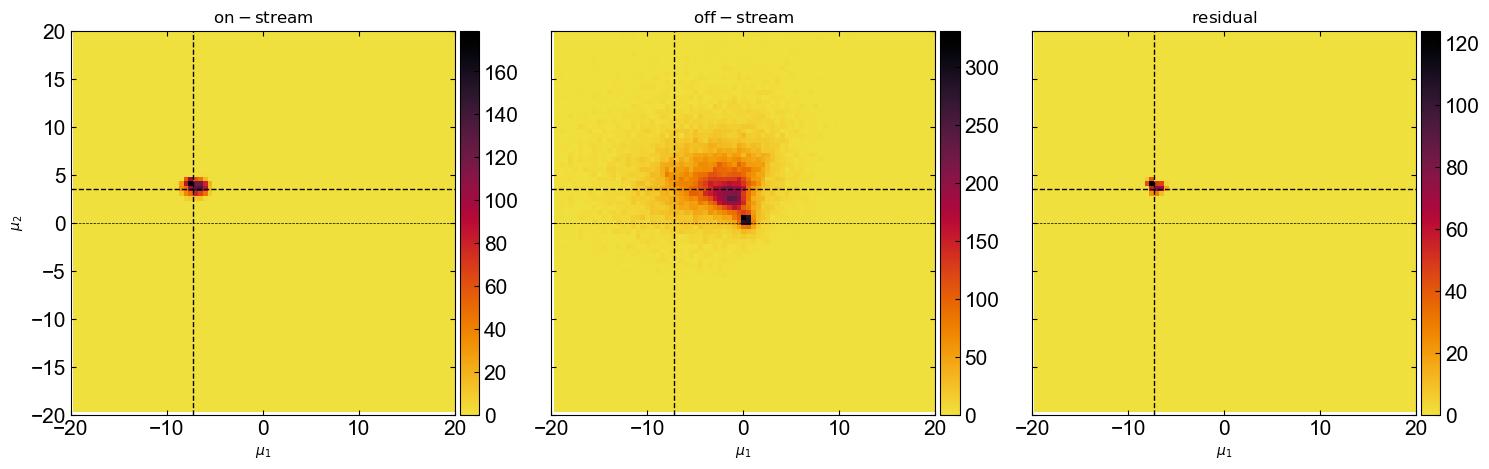

In [6]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [7]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

        Use @ instead. [gala.coordinates.greatcircle]


In [8]:
Base.setup(p, cat)
print(Base.coord_bounds)

{'phi1': (-20.00019019062961, 20.000545839705676), 'phi2': (-7.5279658175419275, 7.720112934502167), 'pm1': (-9.483565830978502, -5.1584011047481715), 'pm2': (1.0014353168114623, 5.755463096989796)}


In [9]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [10]:
len(bkg_data['phi1'])

28573

In [11]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

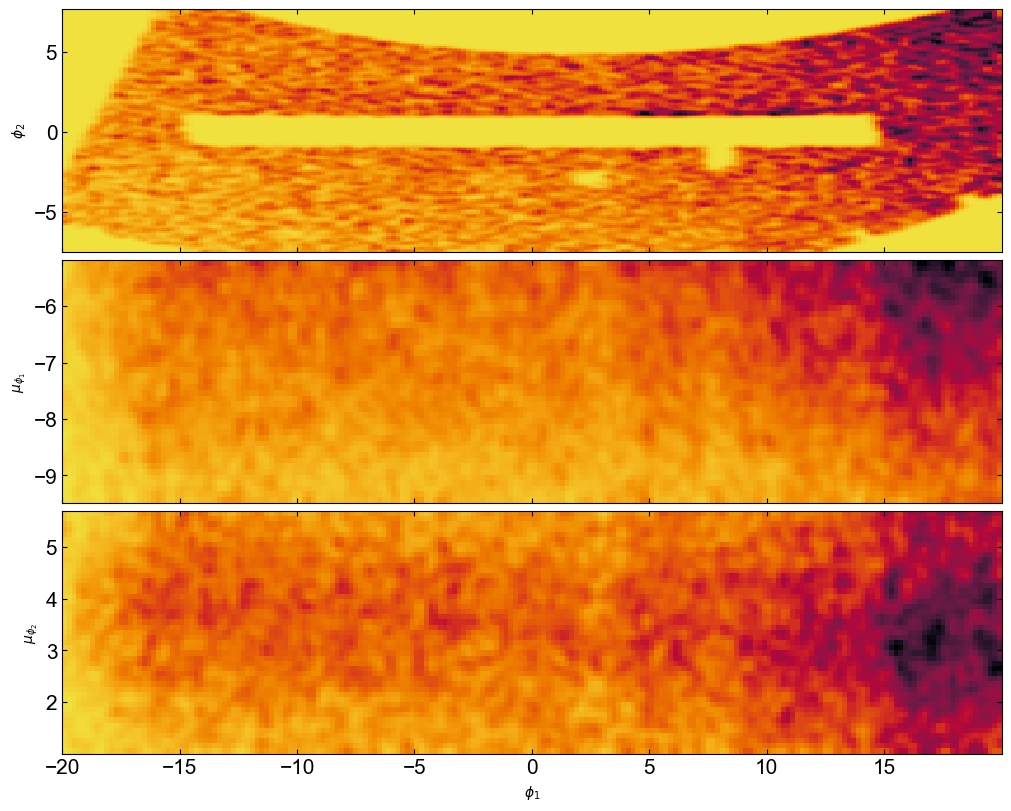

In [12]:
plot_data_projections(data=bkg_data, grids=Base.default_grids,
                      smooth=1);

# Background

In [13]:
BackgroundModel.bkg_update(p, cat)

In [14]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm1_knots, 0),
        "ln_std1": np.full_like(BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm2_knots, 3),
        "ln_std1": np.full_like(BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm2_knots, 4),
        "ln_std2": np.full_like(BackgroundModel.pm2_knots, 2)
    },
}

background_init = BackgroundModel(bkg_init_p)

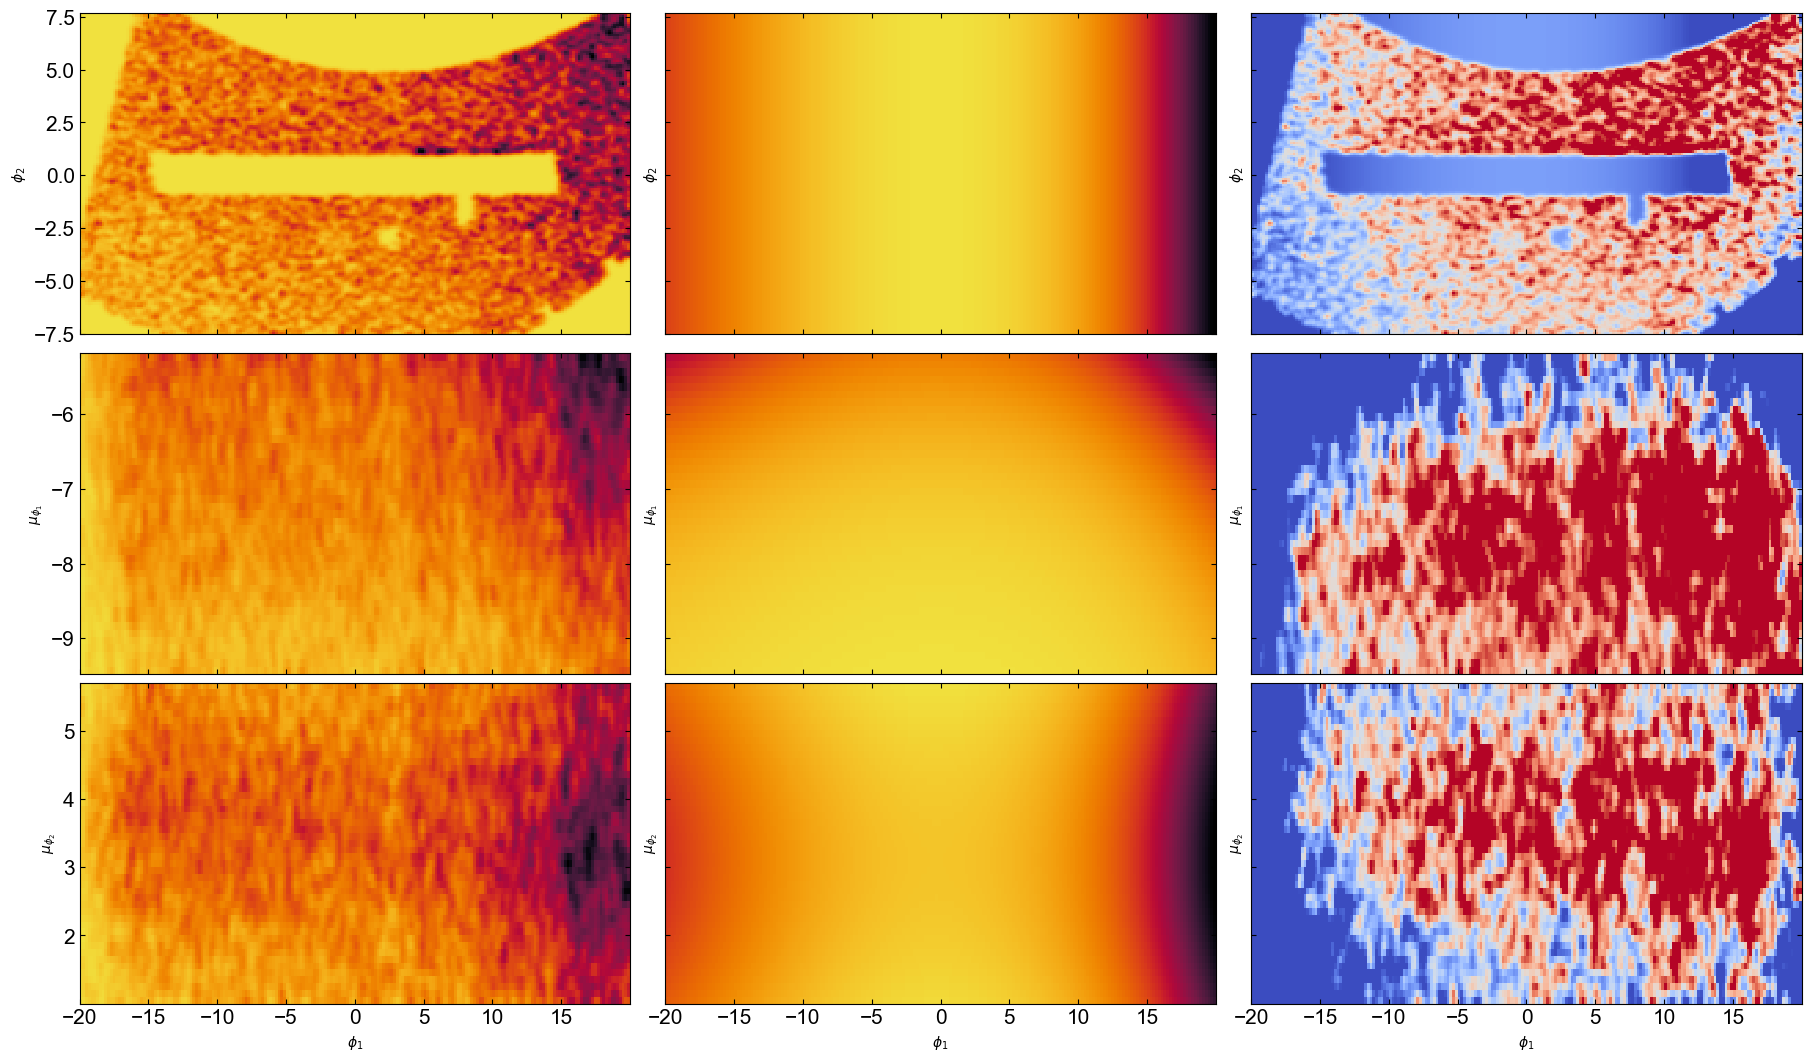

In [15]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

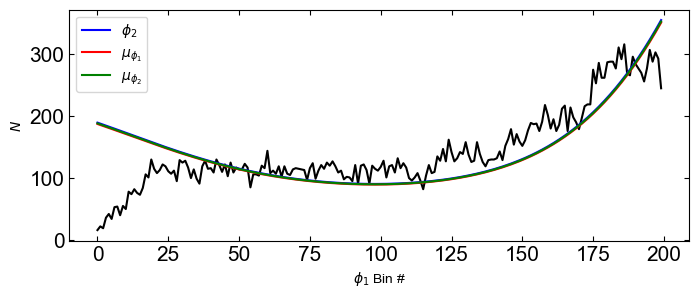

In [16]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [17]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [18]:
bkg_opt_pars, bkg_info = BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(0.01456728, dtype=float64, weak_type=True), success=True, status=0, iter_num=52, hess_inv=LbfgsInvHessProduct(sk=[[-4.47876711e-04 -1.47285864e-04 -4.10749303e-04  1.20079284e-03
   1.11105653e-03 -5.52663648e-06 -2.90774305e-04  7.11802665e-05
  -2.53551701e-04 -1.23284583e-03  6.60152825e-04  2.51887999e-03
   5.56504988e-04 -2.20197958e-06 -6.09342598e-06  3.95830151e-05
   9.77524298e-05  4.95222173e-04  3.24631697e-04  1.56922263e-05
  -2.14528887e-05 -5.78410861e-05 -6.75310657e-05 -3.10367463e-04
  -6.42361581e-05  4.69545905e-06  1.19773861e-06 -8.12126895e-06
  -3.76709390e-05 -5.64893560e-05 -3.22438628e-05 -2.69092992e-07
   6.02889479e-04  0.00000000e+00  3.19642928e-04  0.00000000e+00
   9.93075497e-05  1.31358813e-10  6.48929082e-05 -5.28273623e-04
  -2.80122716e-04  6.04632410e-04  8.83959506e-05  2.66617233e-05
  -2.37064509e-04 -3.36294975e-04  1.96878356e-04 -2.36210925e-04
  -2.40604765e-04 -2.47489105e-05  2.37484006e-04  1.38613122e-

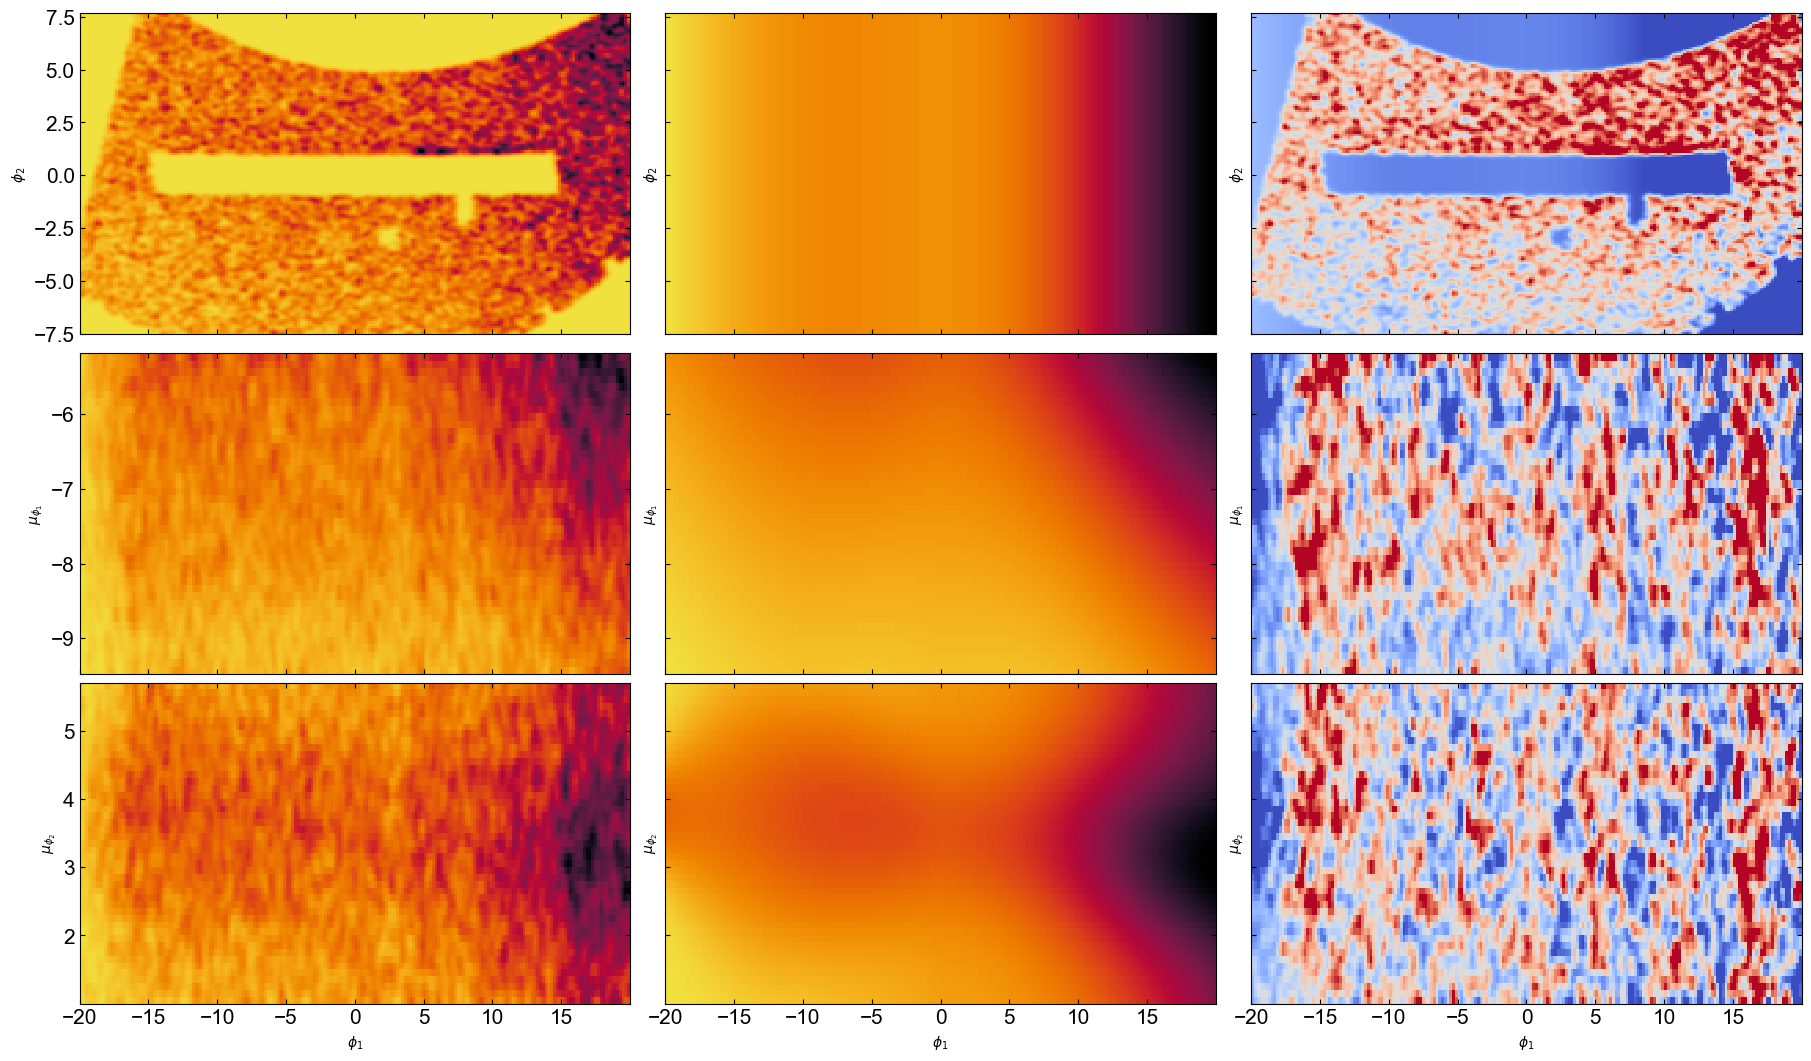

In [19]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('jhelum_background.png')

Spline times a spline to get phi1 phi2

# Stream

In [20]:
StreamDensModel.stream_dens_update(p, cat)

In [21]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-15, 15, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-15, 15, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-15, 15, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [22]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

        Use @ instead. [gala.coordinates.greatcircle]


In [23]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, -1)
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -1)
    }
}

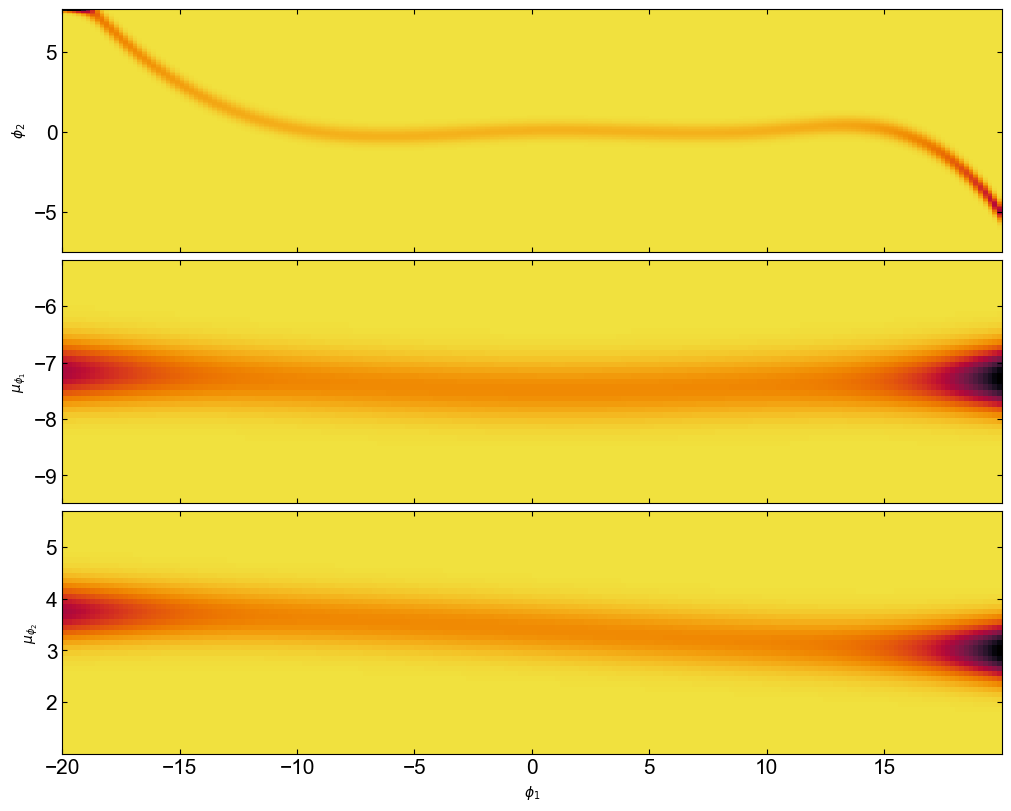

In [24]:
stream_init = StreamDensModel(stream_init_p)
_ = stream_init.plot_model_projections()

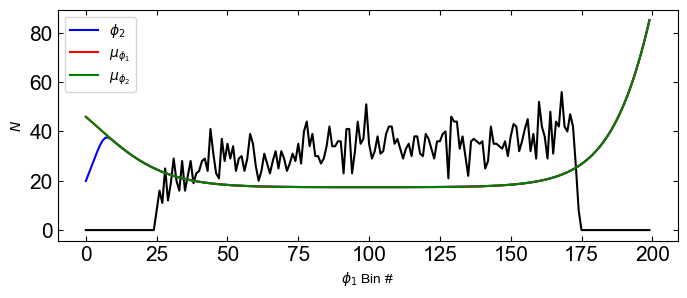

In [25]:
H_data1, *_ = np.histogram2d(
    stream_data["phi1"],
    stream_data["phi2"],
    bins=(stream_init.default_grids["phi1"], stream_init.default_grids['phi2'])
)

grids, ln_ns = stream_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [26]:
stream_init_p

{'ln_N': 8.4906438561827,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([  9.90329987,   0.17580646,   0.07855136,   0.06280095,
          -5.15042637, -58.74923829]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])},
 'pm1': {'mean': array([-7.1584011 , -7.32658267, -7.4808447 , -7.40147847, -7.27759879,
         -7.27759879]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([3.7554631 , 3.64331886, 3.41709698, 3.15647848, 3.00143532,
         3.00143532]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])}}

In [31]:
stream_opt_pars, info = StreamDensModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=False
)
stream_opt = StreamDensModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.12472907, dtype=float64, weak_type=True), success=False, status=2, iter_num=124, hess_inv=Array([[ 1.00000000e+00,  1.53472151e-09,  1.44413074e-09, ...,
        -2.67624958e-10,  2.60856121e-10, -6.65282721e-10],
       [ 1.53472151e-09,  4.92074603e+04,  4.63031638e+04, ...,
        -8.59058365e+03,  8.34484657e+03, -2.12962959e+04],
       [ 1.44413074e-09,  4.63031638e+04,  4.35721958e+04, ...,
        -8.08351623e+03,  7.85201823e+03, -2.00391521e+04],
       ...,
       [-2.67624958e-10, -8.59058365e+03, -8.08351623e+03, ...,
         1.51273447e+03, -1.45931978e+03,  3.71699960e+03],
       [ 2.60856121e-10,  8.34484657e+03,  7.85201823e+03, ...,
        -1.45931978e+03,  1.44805396e+03, -3.64283764e+03],
       [-6.65282721e-10, -2.12962959e+04, -2.00391521e+04, ...,
         3.71699960e+03, -3.64283764e+03,  9.25246461e+03]],      dtype=float64), num_fun_eval=Array(242, dtype=int32), num_jac_eval=Array(230, dtype=int32), num_hess_eval=Array(0

In [32]:
stream_opt_pars

{'ln_N': Array(8.49064386, dtype=float64),
 'phi1': {'zs': Array([-16.56351271, -15.86795932, -13.1081959 ,  -5.77280931,
           1.06207744,   1.27874714, -10.00461272,  -0.67416036,
          16.39562573,  20.31213581,   9.31220502,   2.8519552 ,
           0.62532564], dtype=float64)},
 'phi2': {'ln_std': Array([-0.72807051, -0.51878777, -0.54512669, -0.56735762, -0.41187647,
          0.19034926], dtype=float64),
  'mean': Array([ 0.25275132,  0.16767345,  0.04581146,  0.09291055, -0.00456208,
         -1.20761963], dtype=float64)},
 'pm1': {'ln_std': Array([2.94846533, 1.71441072, 1.91099074, 2.78082222, 3.54078905,
         3.32717924], dtype=float64),
  'mean': Array([-1.14345459, -1.94636669, -3.13309717, -2.86005416, -2.07182439,
         -1.0229564 ], dtype=float64)},
 'pm2': {'ln_std': Array([3.30461604, 2.79823068, 2.33374196, 2.95796977, 2.80458731,
         3.11268694], dtype=float64),
  'mean': Array([4.33432216, 4.49480315, 3.92448463, 4.10059522, 4.65166808,
       

Text(0, 0.5, '$\\phi_2$')

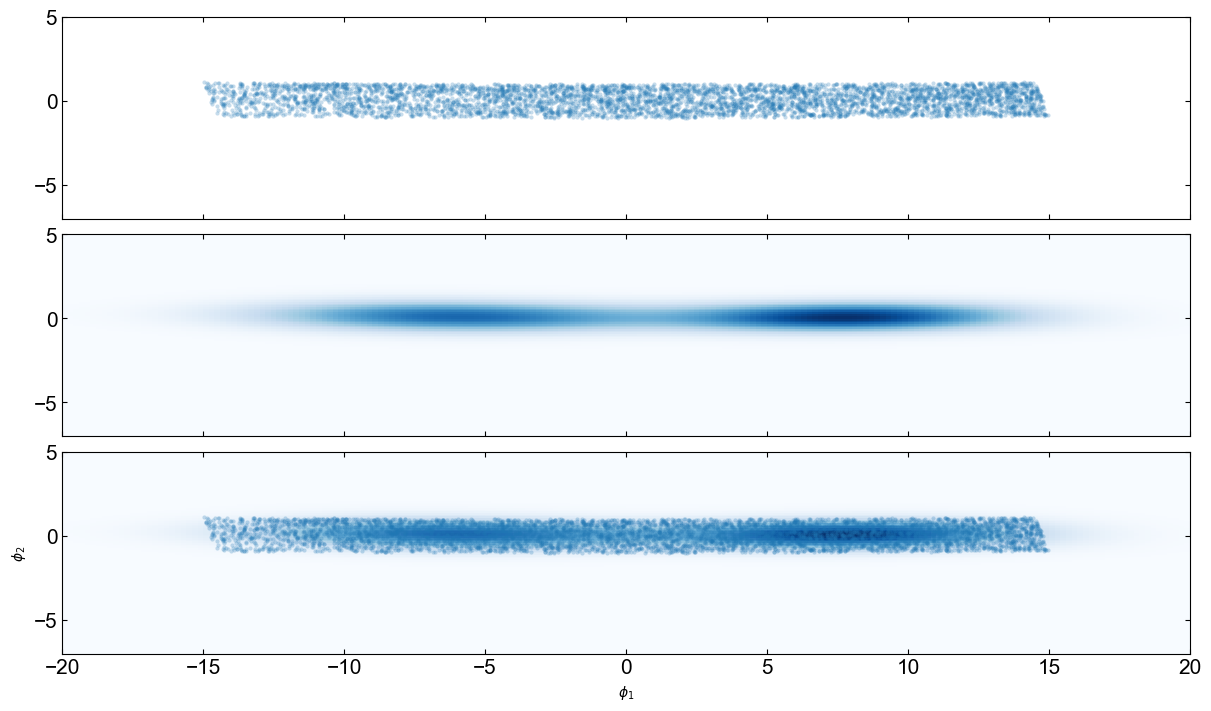

In [33]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-20, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

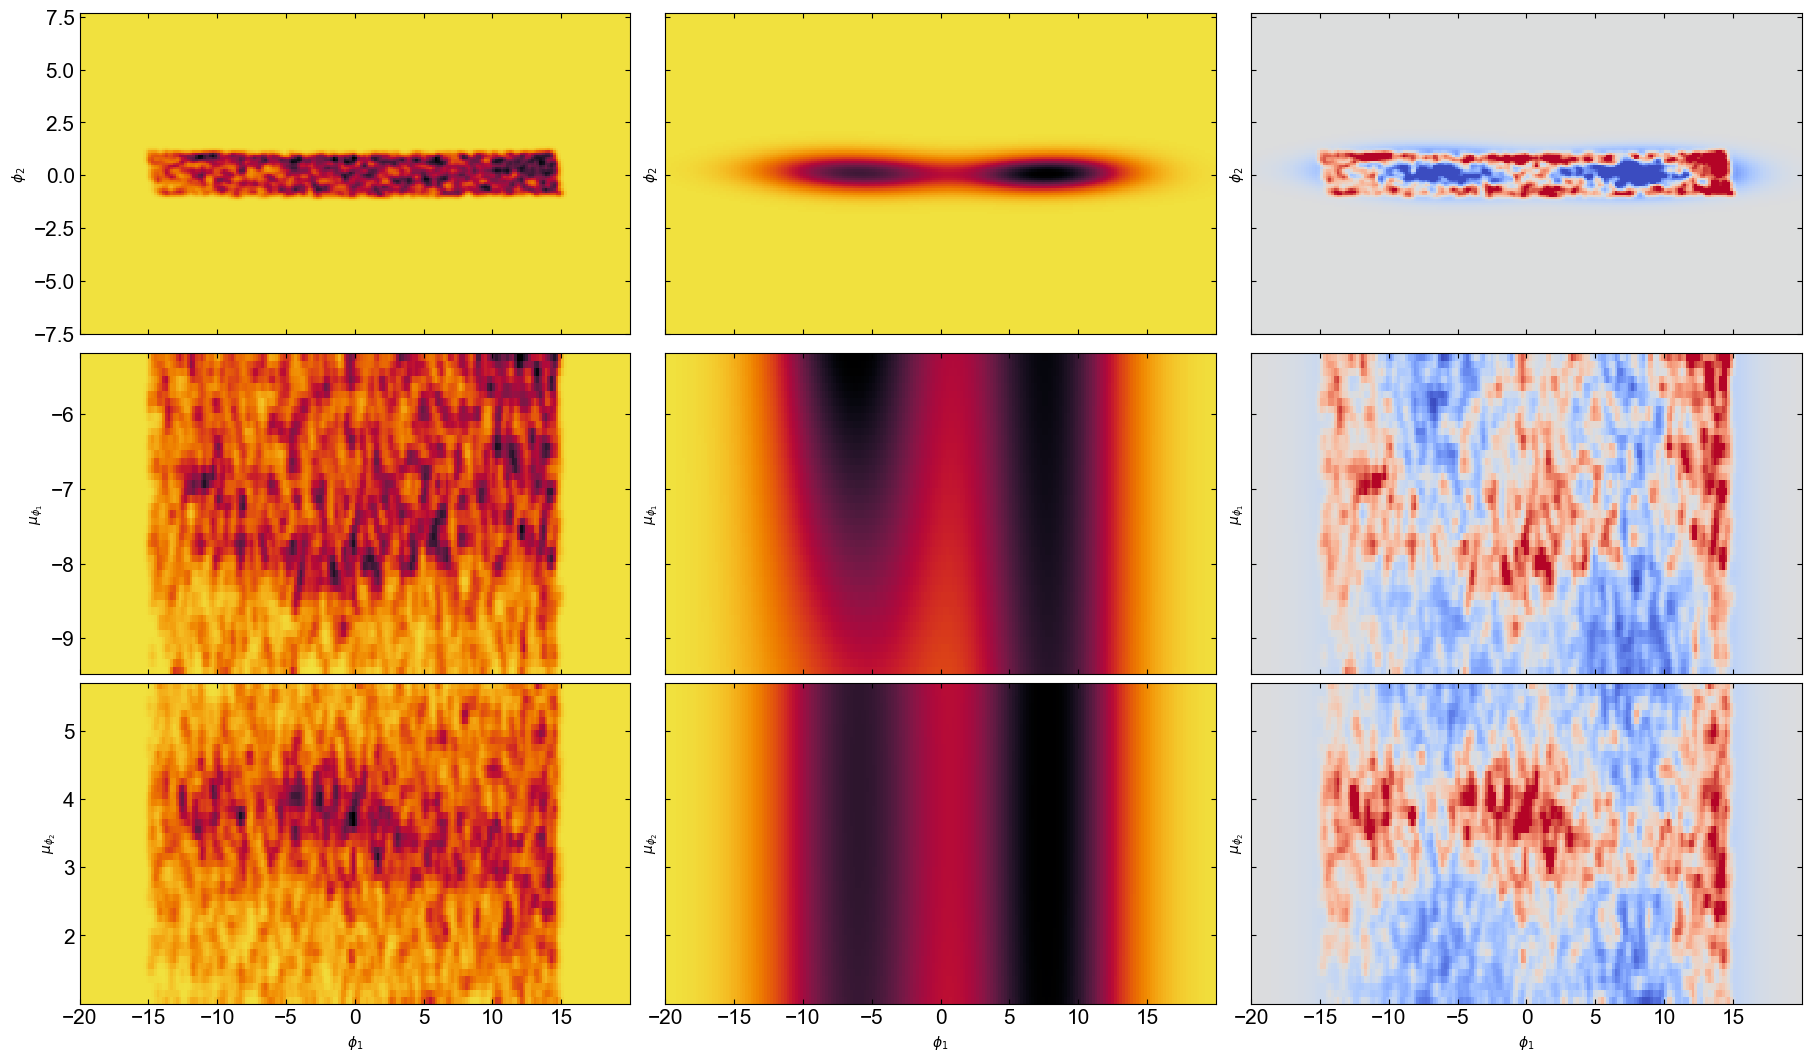

In [34]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [42]:
Components = [StreamDensModel, BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [43]:
mix_init = StreamMixtureModel(mix_params0, Components)

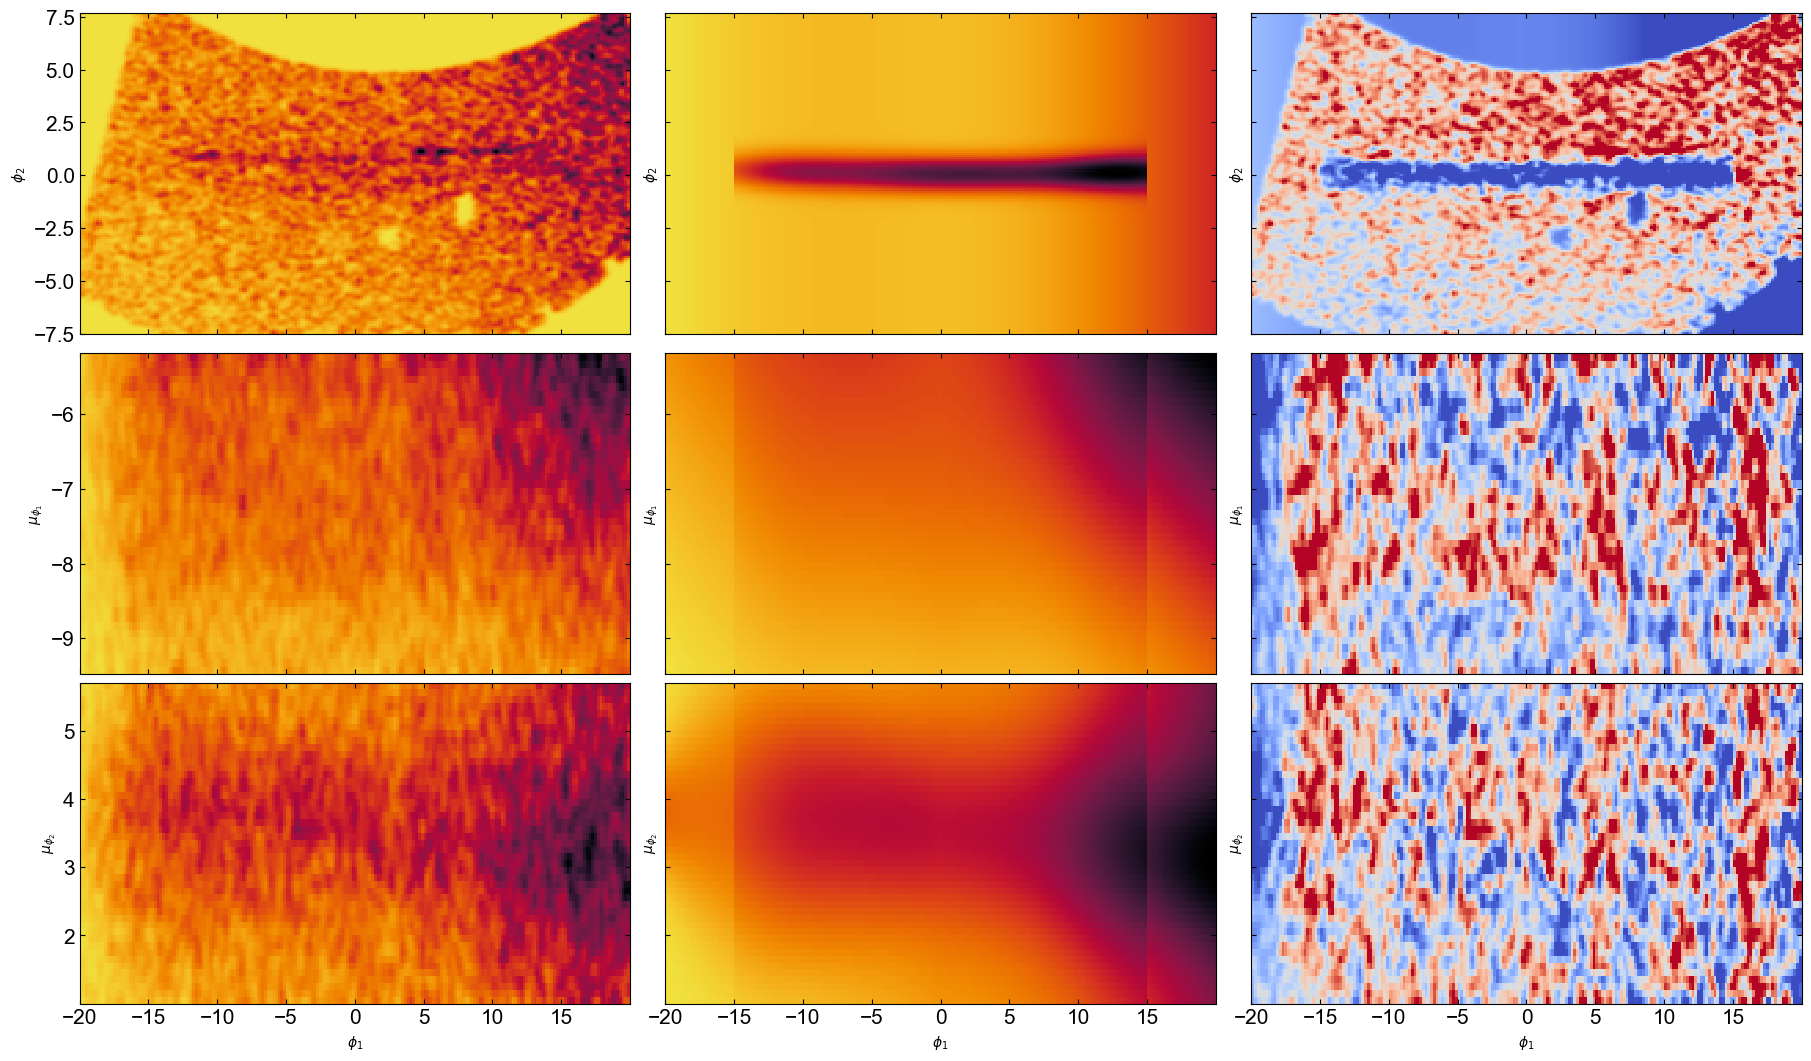

In [44]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [46]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=False
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(nan, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=Array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64), num_fun_eval=Array(112, dtype=int32), num_jac_eval=Array(112, dtype=int32), num_hess_eval=Array(0, dtype=int32))

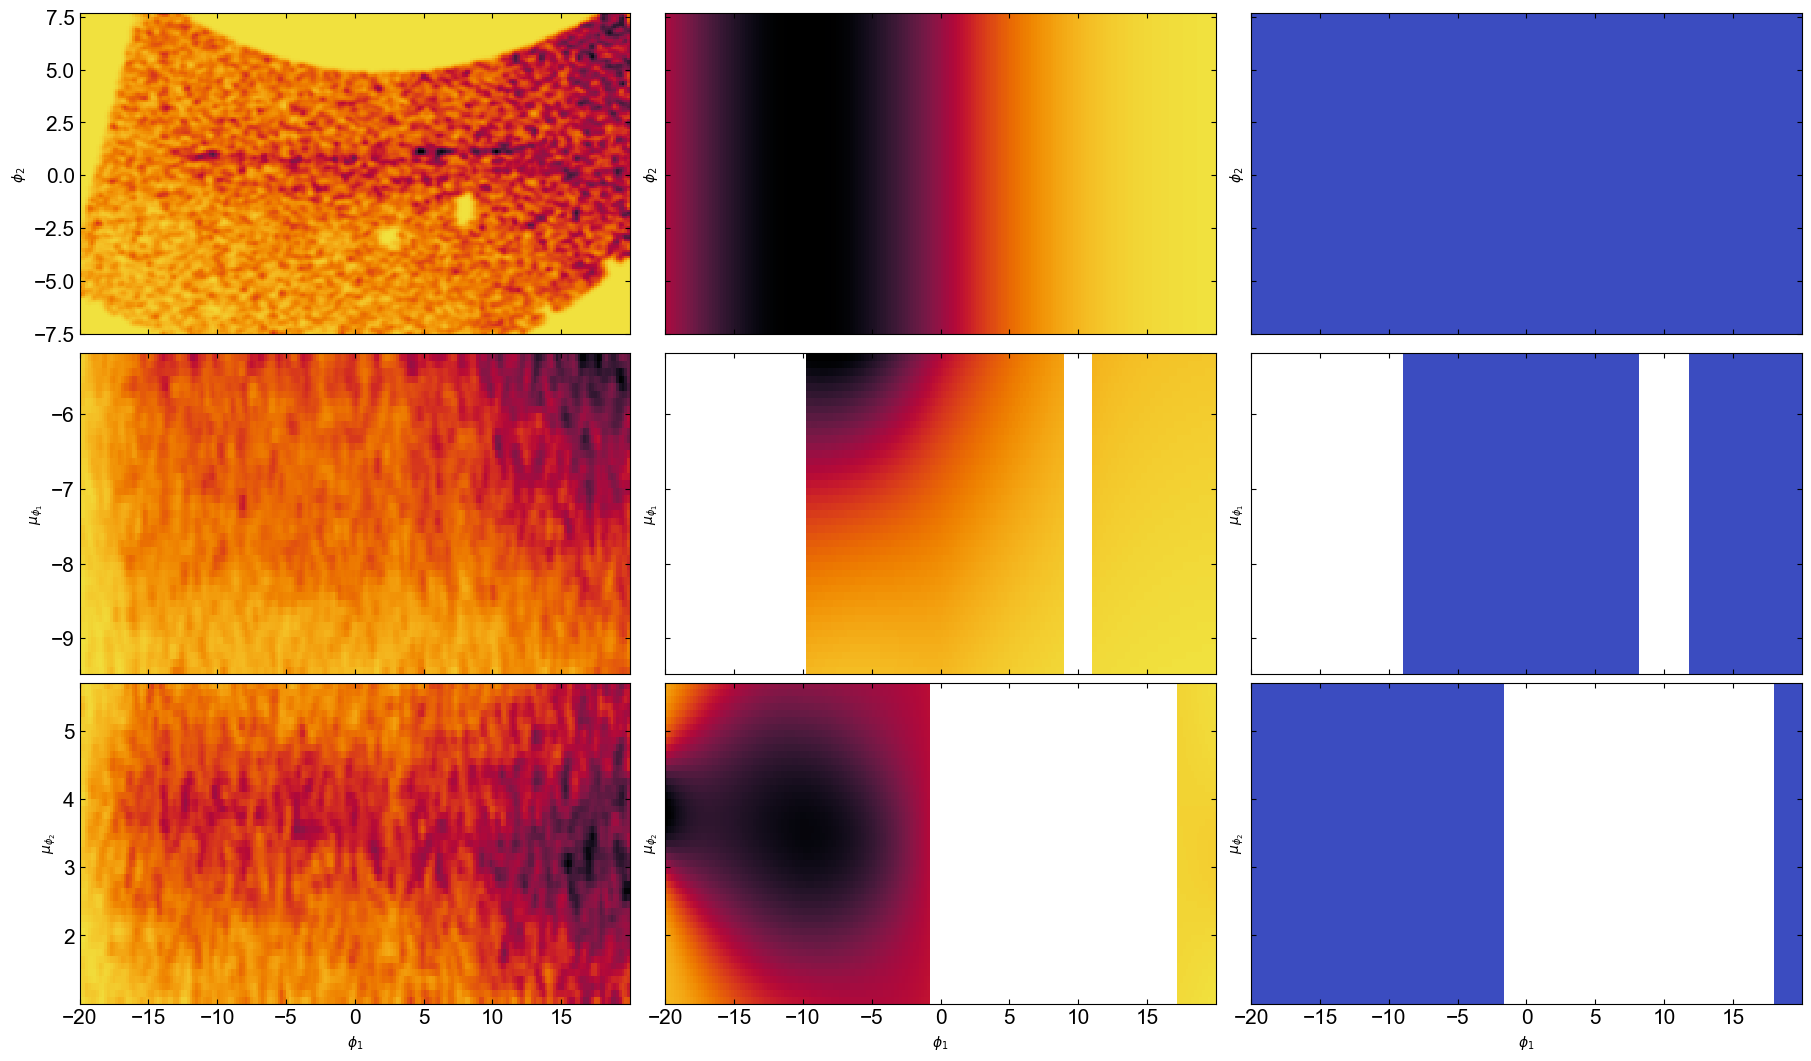

In [47]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [34]:
OffTrackModel.offtrack_update(p, cat)

In [35]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

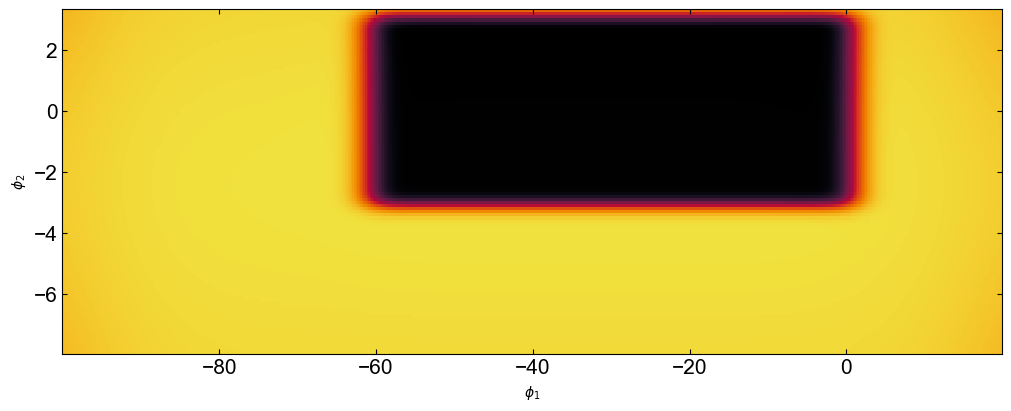

In [36]:
offtrack_model0 = OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [37]:
full_Components = [StreamDensModel, BackgroundModel, OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [38]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [39]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(874,)

In [40]:
tied_params

[(('offtrack', 'pm1'), ('stream', 'pm1')),
 (('offtrack', 'pm2'), ('stream', 'pm2'))]

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

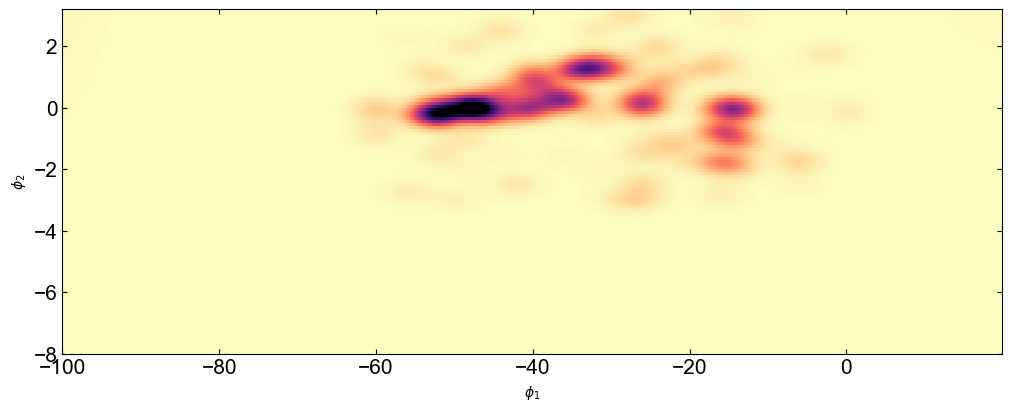

In [75]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

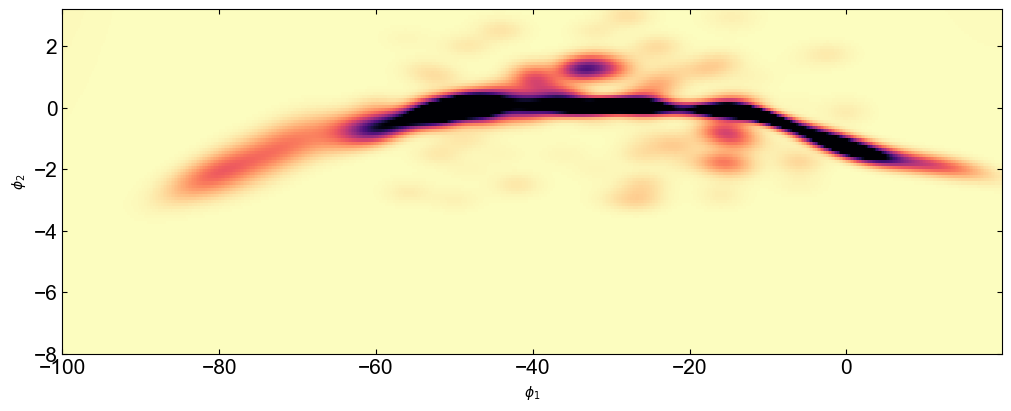

In [76]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

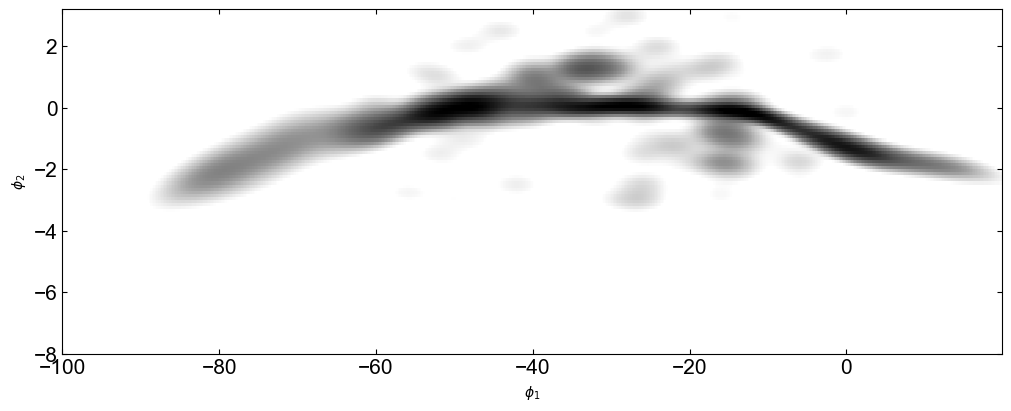

In [77]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='$\\mu_{\\phi_1}$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_2}$'>],
       dtype=object))

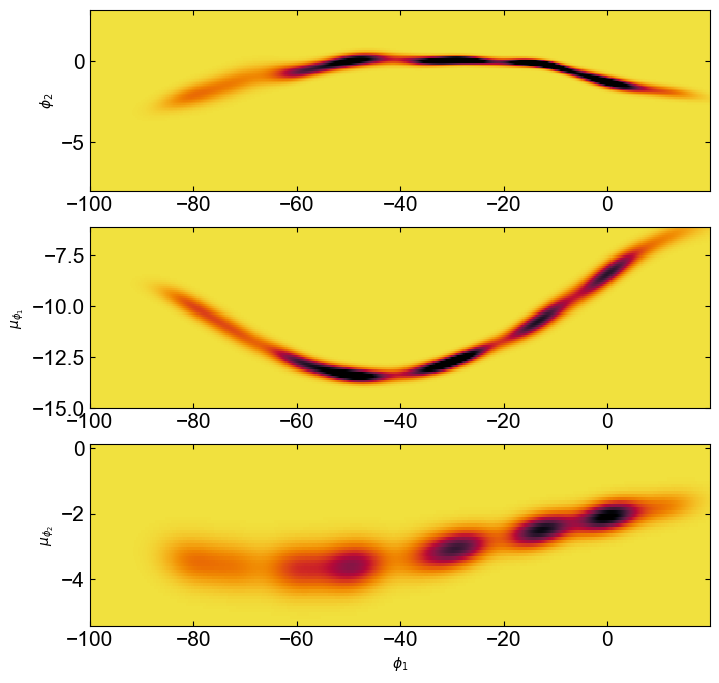

In [82]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

In [81]:
full_mix_opt_pars['stream']

{'ln_N': Array(7.03706969, dtype=float64),
 'phi1': {'zs': Array([-7.37626437, -7.6583479 , -8.        , -8.        , -8.        ,
         -5.02425777,  0.5406238 , -4.54503195,  0.32904079, -1.54314444,
         -3.79818606,  0.96765485, -1.88551909,  0.58504156,  1.19630787,
         -4.4654777 , -2.38322058,  0.14321783,  0.38679703,  1.396316  ,
         -7.07405701, -7.40611595,  0.31449392,  1.71531717, -6.42651825,
         -5.18321947,  3.16739992, -8.        ,  1.00957904,  8.        ,
          3.20953424,  0.85423195], dtype=float64)},
 'phi2': {'ln_std': Array([-0.87416611, -0.88409819, -0.87034153, -0.71859818, -0.77287848,
         -1.21673017, -1.39970243, -1.48266333, -1.74829516, -1.93707973,
         -1.93313831, -1.97178721, -1.63594016, -1.55971143, -1.52073622,
         -1.49376808], dtype=float64),
  'mean': Array([-3.08506317, -3.16330564, -2.46418878, -1.72245427, -0.94234142,
         -0.64553855, -0.10985543,  0.14784986,  0.0275281 ,  0.06451962,
         -0

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

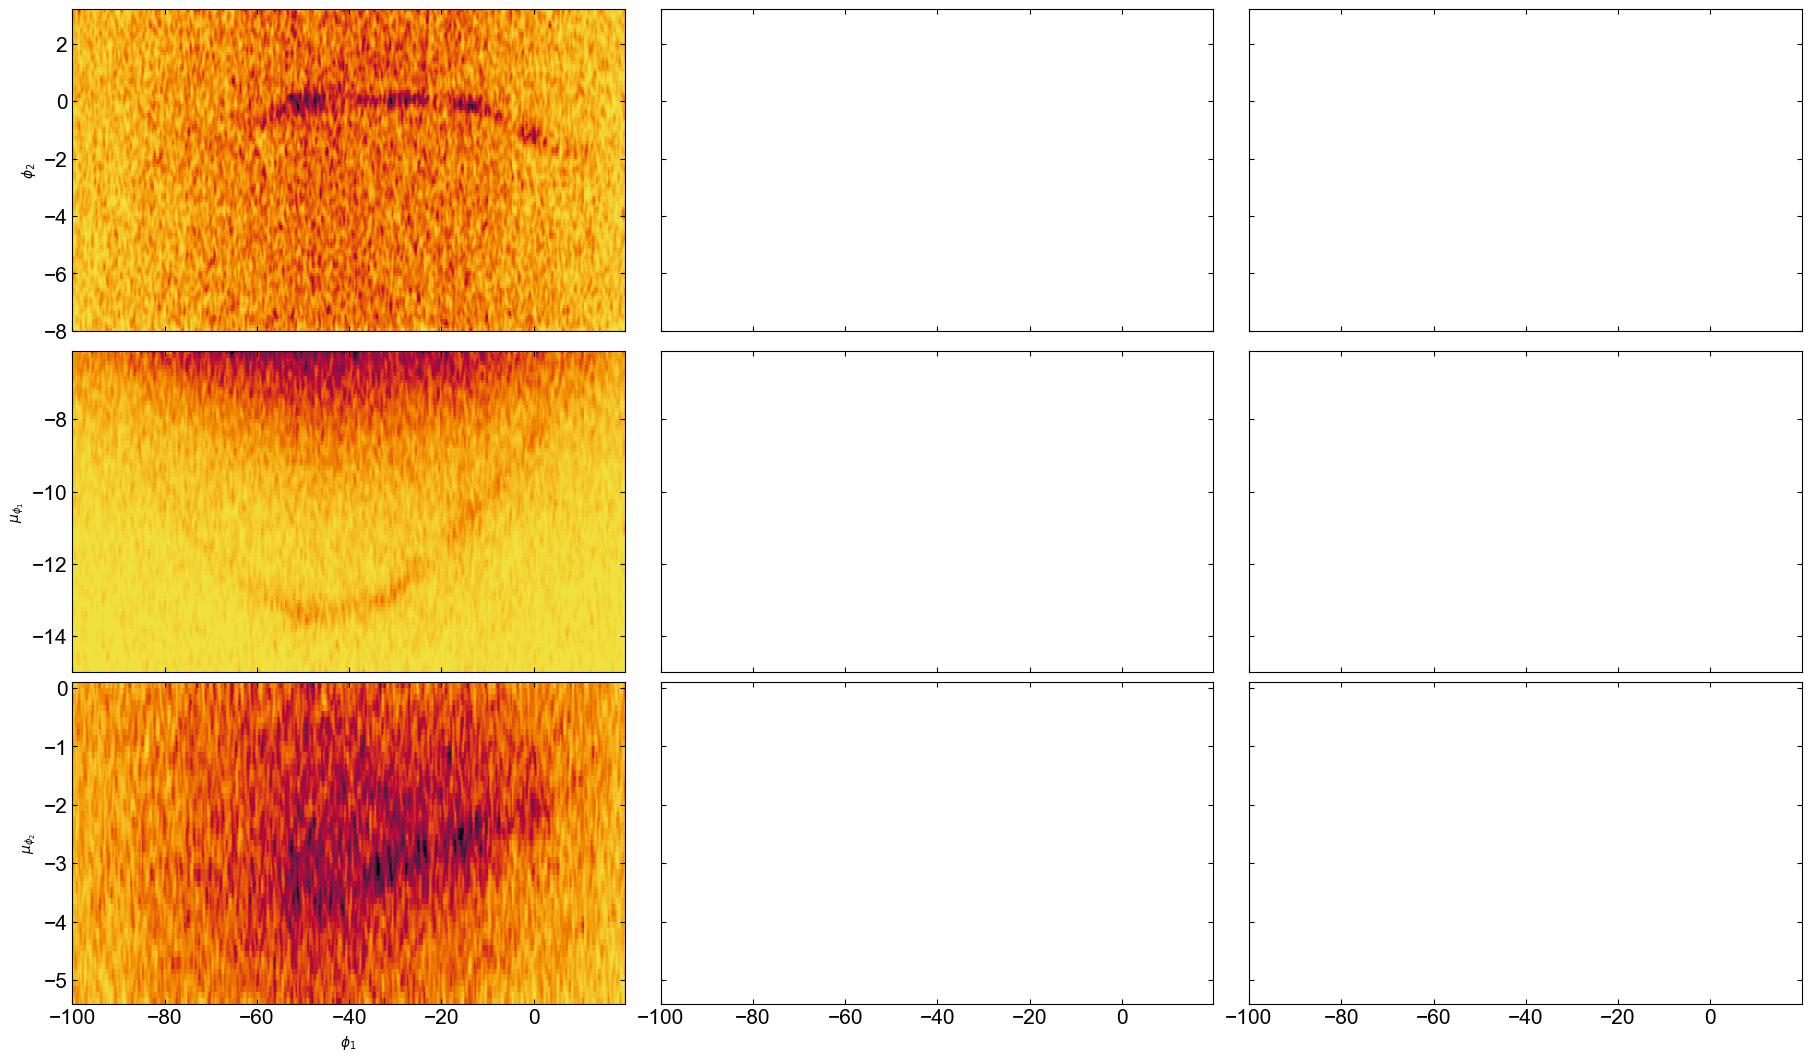

In [80]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")